<a href="https://colab.research.google.com/github/Collinjia/Image_recognization/blob/main/Image%20Recognization%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognization Practice

## Installation
Instructions can be found here:
* [Tensorflow](https://www.tensorflow.org/install/)

Since Tensorflow 2.0, Keras is included in Tensorflow and will be automatically installed with Tensorflow. It can be accessed as ```tensorflow.keras```

I recommend installing using ```pip```. For Tensorflow is it sufficient to install the CPU version. The GPU version requires a good workstation with high-end Nvidia GPU(s), and it is not necessary for this tutorial.

If you're using a virtualenv:
```
pip3 install tensorflow
```
Add ```sudo``` for a systemwide installation (i.e. no ```virtualenv```).
```
sudo pip3 install tensorflow
```
Make sure that you have ```sklearn```, ```matplotlib``` and ```numpy``` installed, too.


## Part 1 - understand a model

### Optimizers

Loss is the penalty for a bad prediction. That is, loss is a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater than zero. The goal of training a model is to find a set of weights and biases (i.e. parameters) that have, on average, a low loss across all examples. The term cost is used interchangably with loss. See the [loss section](https://keras.io/losses/) in the Keras documentation for a list and descriptions of what is available.

![Side by side loss](https://drive.google.com/uc?id=1DdbQEQLCLCSw4uPsuf0C1nJCfUICT0Ae)
<b>Figure 1.</b> Left: high loss and right: low loss.

<!-- https://drive.google.com/file/d/1DdbQEQLCLCSw4uPsuf0C1nJCfUICT0Ae/view?usp=sharing
<img src="./fig/LossSideBySide.png" width="500">
<figcaption>Figure. Left: high loss and right: low loss.</figcaption>
 -->
The optimizer is the algorithm used to minimize the loss/cost. Optimizers in neural networks work by finding the gradient/derivative of the loss with respect to the parameters (i.e. the weights). "Gradient" is the correct term since a we are looking at multi-dimensional systems (i.e. many parameters), however, the terms are often used interchangably. For those who didn't take multivariate calculus, just think of the gradient as a derivative. The derivative of the loss with respect to a parameters tells us how much the loss changes when we nudge a weight up or down. So, by knowing how a given parameter affects the loss the optimizer can change it so as to decrease the loss. The various optimizers differ in how they change the weights. 

#### Mini-overview over popular optimizers

* **Stochastic Gradient Descent (SGD)**. This is the most basic and easy to understand optimizer. It updates the weights in the negative direction of the gradient by taking the average gradient of mini-batch of data (e.g. 20-1000 examples) in each step. Vanilla SGD only has one hyper-parameter, the learning rate.
* **Momentum**. This optimizer "gains speed" when the gradient has pointed in the same direction for several consecutive updates. That is, it has a momentum and want to keep moving in that direction. It gains momentum by accumulating an exponentially decaying moving average of past gradients. The step size depends on how large and aligned the sequence of gradients are. The most important hyper-parameter is alpha and common values are 0.5 and 0.9.
* **Nesterov Momentum**. This is a modification of the standard momentum optimizer.
* **AdaGrad**. This optimizer Ada-ptively sets the learning rate depending on the steepness/magnitude of the Grad-ients. This is done so that weights with big gradients get a smaller effective learning rate, and weights with small gradients will get a greater effective learning rate. The result is quicker progress in the more gently sloped directions of the weight space and a slowdown in stepp regions.
* **RMSProp**. This is modification of AdaGrad, where the accumulated gradient decays, that is, the influence of previous gradients gradually decreases.
* **Adam**. The name comes from "adaptive moments", and it is a combination of RMSProp and momentum. It has several hyper-parameters.

The above list just gives a quick overview of some of the most common. However, old optimizers are constantly improved and new are developed. SGD and momentum are most basic and easiest to understand and implement. They are still in use, but the more advanced optimizers tend to be better for practical use. Which one to use is generally an emperical question depending on both the data and the model.

For a more complete overview of optimization algorithms see [this comparison](http://ruder.io/optimizing-gradient-descent/), and to see what is available in Keras, see the [optimizer section](https://keras.io/optimizers/) of the documentation.

See the images below for a comparison of optimizers in a 2D space (NAG: Nesterov accelerated gradient, Adadelta: an extension of AdaGrad).

![Contours - optimizer comparison](https://drive.google.com/uc?id=1CmrD-UPZ7EIUjRuO_ib7k9CL1FO2bbLk)
<b>Figure 2.</b> Comparison of six different optimizers.


![Saddle point - optimizer comparison](https://drive.google.com/uc?id=1QVhN9rAvCjXtGyNZkmFivyyCzNsntObh)
<b>Figure 3.</b> Comparison of six different optimizers at a saddle point.

<!-- <img src="./fig/contours_evaluation_optimizers.gif" width="500">
<img src="./fig/saddle_point_evaluation_optimizers.gif" width="500"> -->

In [ ]:
# imports
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# for the random seed
import tensorflow as tf

# set the random seeds to get reproducible results
np.random.seed(1)
tf.random.set_seed(2)

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = X[:1000], y[:1000]
X = X.reshape(X.shape[0], 28, 28, 1)
# Normalize
X = X / 255.
# number of unique classes
num_classes = len(np.unique(y))
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

num_tot = y.shape[0]
num_train = y_train.shape[0]
num_test = y_test.shape[0]

y_oh = np.zeros((num_tot, num_classes))
y_oh[range(num_tot), y] = 1

y_oh_train = np.zeros((num_train, num_classes))
y_oh_train[range(num_train), y_train] = 1

y_oh_test = np.zeros((num_test, num_classes))
y_oh_test[range(num_test), y_test] = 1

### Question 1
**The data set**

Plot a three examples from the data set.
* What type of data are in the data set?

  <font color='blue'> All data are 28*28 images. </font>
    

* What does the line ```X = X.reshape(X.shape[0], 28, 28, 1)``` do?

  <font color='blue'> Reshape the numpy array from (1000, 784) to (1000, 28, 28, 1) so that it can be taken as the input layer. Because there are 1000 images and each image is 28*28.</font>

Look at how the encoding of the targets (i.e. ```y```) is changed. E.g. the lines
```
    y_oh = np.zeros((num_tot, num_classes))
    y_oh[range(num_tot), y] = 1
```
Print out a few rows of ```y``` next to ```y_oh```.
* What is the relationship between ```y``` and ```y_oh```?

  <font color='blue'>y_oh is the one-hot encoding matrix form of y. If y[i] is n, then y_oh will have 1 on the nth number and all else zero in the i row. </font> 
    
* What is the type of encoding in ```y_oh``` called and why is it used?

  <font color='blue'> One-hot encoding. Because we need to code for categorical values without giving them an order. </font>
    
    
* Plot three data examples in the same figure and set the correct label as title. 
    * It should be possible to see what the data represent.

first 5 elements of y:  [5 0 4 1 9]
first 5 elements of y_oh: 
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


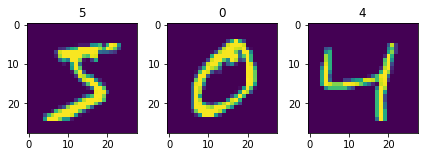

In [ ]:
# print out first 5 rows of y and y_oh.
print("first 5 elements of y: ",y[:5])
print("first 5 elements of y_oh: ")
print(y_oh[:5])

# Show the data example of the first three data
# Reshape the X into 28*28 images.
X_plot = X.reshape(X.shape[0], 28, 28)
# create the empty list for subplot
ax = []
rows = 1
cols = 3
fig=plt.figure()

for i in range(rows*cols):
    # create the subplot and append to ax
    ax.append(fig.add_subplot(rows,cols,i+1))
    # set the title of subplots
    ax[-1].set_title(y[i])
    plt.imshow(X_plot[i])
    # Increase the space between subplots
    fig.tight_layout()

plt.show()

### Question 2
**The model**

Below is some code for bulding and training a model with Keras.
* What type of network is implemented below? I.e. a normal MLP, RNN, CNN, Logistic Regression...?

  <font color='blue'> CNN </font>
    
    
* What does ```Dropout()``` do?

  <font color='blue'> The code add a dropout layer into the model. The dropout layer randomly sets input units to 0 with a frequency of given rate.It randomly remove neurons to prevent overfitting. </font>


* Which type of activation function is used for the hidden layers?

  <font color='blue'> Relu function </font>


* Which type of activation function is used for the output layer?

  <font color='blue'> softmax function </font>


* Why are two different activation functions used?

  <font color='blue'> Normally we choose different activision function for hidden layers and output layer. For hidden layers, it depends on the type of neurual network. Since this network is CNN structure, we choose ReLU activition.
    
    For output layer, it depends on the what prediction that we want to make. Since this network is design for the multiclass classification, we choose softmax activation.
  </font>


* What optimizer is used in the model below?

  <font color='blue'> Nesterov momentum SGD optimizer </font>


* How often are the weights updated (i.e. after how many data examples)?

  <font color='blue'> 32. Because the batch size = 32. </font>


* What loss function is used?

  <font color='blue'> categorical crossentropy </font>


* How many parameters (i.e. weights and biases, NOT hyper-parameters) does the model have?

  <font color='blue'> 108,618 parameters </font>


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD


model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.))

model.add(Conv2D(32, (3, 3), activation='relu'))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.))

model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd)

# Train the model
model.fit(X_train, y_oh_train, batch_size=32, epochs=60)

# Evaluate performance
test_loss = model.evaluate(X_test, y_oh_test, batch_size=32)

predictions = model.predict(X_test, batch_size=32)
predictions = np.argmax(predictions, axis=1) # change encoding again
print('Accuracy:', (predictions == y_test).sum() / predictions.shape[0])

In [ ]:
# show the summary of the model.
model.summary()

## Part 2 - train a model

A model's performance depends on many factors apart from the model architecture (e.g. type and number of layers) and the dataset. Here you will get to explore some of the factors that affect model performance. Much of the skill in training deep learning models lies in quickly finding good values/options for these choises.

In order to observe the learning process it is best to compare the training set loss with the loss on the test set. How to visualize these variables with Keras is described under [Training history visualization](https://keras.io/visualization/#training-history-visualization) in the documentation.

You will explore the effect of 1) optimizer, 2) training duration, and 3) dropout (see the question above).

When training, an **epoch** is one pass through the full training set.

### Question 3

* **Vizualize the training**. Use the model above to observe the training process. Train it for 150 epochs and then plot both "loss" and "val_loss" (i.e. loss on the valiadtion set, here the terms "validation set" and "test set" are used interchangably, but this is not always true). What is the optimal number of epochs for minimizing the test set loss? 
    * Remember to first reset the weights (this can be done by calling ```model.compile()```), otherwise the training just continues from where it was stopped earlier.
  
  <font color='blue'> In this model, the test set loss is minimized in epochs 9 with the value = 0.2801</font>


* **Optimizer**. Select three different optimizers and for each find the close-to-optimal hyper-parameter(s). In your answer, include a) your three choises, b) best hyper-parameters for each of the three optimizers and, c) the code that produced the results.
    * *NOTE* that how long the training takes varies with optimizer. I.e., make sure that the model is trained for long enough to reach optimal performance.

  <font color='blue'> a) Optimizer chosen: SGD, Nesterov Momentum SGD and Adam</font>

  <font color='blue'>
  b) For SGD, I use epochs = 150. And for Nesterov and Adam, since they are learning faster, I decrease the epochs to 60.

  *   For SGD, the optimal learning rate is 0.01 with validation accuracy=0.9250.
  *   For Nesterov Momentum SGD, the optimal learning rate is 0.01 and momentum is 0.5 with validation accuracy=0.9300.
  *   For Adam, the optimal learning rate is 0.01 with validation accuracy=0.9600.

  So the best optimizer is Adam.

  </font>

* **Dropout**. Use the best optimizer and do hyper-parameter seach and find the best value for ```Dropout()```.
  
  <font color='blue'> 
  Based on the result before, we use Adam optimizer with learning rate=0.01 to get the optimal dropout rate.

  The best value for dropout rate=0.5 with validation accuracy = 0.9675.
  
  </font>

* **Best model**. Combine the what you learned from the above three questions to build the best model. How much better is it than the worst and average models?

  <font color='blue'> The best model (Adam with lr = 0.01 and dropout rate = 0.5) has an accuracy rate of 0.9675, which is better than the initial one with accuracy rate of 0.9250. </font>


* **Results on the test set**. When doing this search for good model configuration/hyper-parameter values, the data set was split into *two* parts: a training set and a test set (the term "validation" was used interchangably wiht "test"). For your final model, is the performance (i.e. accuracy) on the test set representative for the performance one would expect on a previously unseen data set (drawn from the same distribution)? Why?

  <font color='blue'> Yes, the test set performance will represent the performance expected on the unseen data set. Because they are drawn from the same distribution. </font>


## Further information
For ideas about hyper-parameter tuning, take a look at the strategies described in the sklearn documentation under [model selection](https://scikit-learn.org/stable/model_selection.html), or in this [blog post](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html) from TensorFlow. For a more thorough discussion about optimizers see [this video](https://www.youtube.com/watch?v=DiNzQP7kK-s) discussing the article [Descending through a Crowded Valley -- Benchmarking Deep Learning Optimizers](https://arxiv.org/abs/2007.01547).


**Good luck!**

In [ ]:
# install the keras tuner for parameter tuning
%pip install -U keras-tuner

### Vizualize the Training

Epoch 1/150
25/25 [==============================] - 2s 38ms/step - loss: 2.2322 - accuracy: 0.2112 - val_loss: 1.8012 - val_accuracy: 0.4500
Epoch 2/150
25/25 [==============================] - 1s 24ms/step - loss: 1.3094 - accuracy: 0.6463 - val_loss: 0.7979 - val_accuracy: 0.7600
Epoch 3/150
25/25 [==============================] - 1s 22ms/step - loss: 0.5476 - accuracy: 0.8214 - val_loss: 0.4619 - val_accuracy: 0.8600
Epoch 4/150
25/25 [==============================] - 1s 22ms/step - loss: 0.3458 - accuracy: 0.9075 - val_loss: 0.3852 - val_accuracy: 0.8900
Epoch 5/150
25/25 [==============================] - 1s 22ms/step - loss: 0.2481 - accuracy: 0.9129 - val_loss: 0.3712 - val_accuracy: 0.8950
Epoch 6/150
25/25 [==============================] - 1s 22ms/step - loss: 0.1618 - accuracy: 0.9439 - val_loss: 0.3957 - val_accuracy: 0.8900
Epoch 7/150
25/25 [==============================] - 1s 22ms/step - loss: 0.1702 - accuracy: 0.9457 - val_loss: 0.3445 - val_accuracy: 0.9100
Epoch 

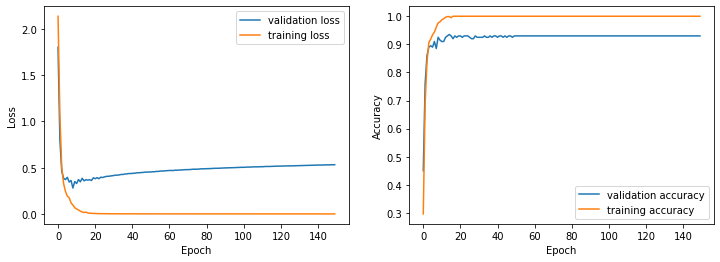

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

# Build the model
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.))

model.add(Conv2D(32, (3, 3), activation='relu'))
# Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.))

model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_oh_train, 
                    batch_size=32, epochs=150,
                    validation_data = (X_test, y_oh_test))

# Visualize the training
fig = plt.figure(figsize=(12,4))
ax0 = fig.add_subplot(121)
# plot the training history for loss
ax0.plot(history.history['val_loss'], label='validation loss')
ax0.plot(history.history['loss'], label='training loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax0.legend()
# plot the training history for accuracy
ax1 = fig.add_subplot(122)
ax1.plot(history.history['val_accuracy'], label='validation accuracy')
ax1.plot(history.history['accuracy'], label='training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()


### Hyperparameter Tuning - Optimizer: Basic Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Define the function that build the basic model for optimizer tuning, 
# which only add layers without complying.
def build_basic_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    # Max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.))

    model.add(Dense(10, activation='softmax'))

    return model

### Hyperparameter Tuning - Optimizer: SGD
Optimal Result: Learning rate = 0.01

With validation Accuracy=0.9250

In [ ]:
from tensorflow.keras.optimizers import SGD
from kerastuner.tuners import RandomSearch

# Define the function that build sgd model
def build_sgd_model(hp):
    # Get the basic model
    model = build_basic_model()
    # Learning rate is chosen from three options: 0.01,0.001 and 0.0001
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=SGD(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    return model
# Define the tuning procedure by RandomSearch method
# The objective is to maximize the validation accuracy
tuner = RandomSearch(
    build_sgd_model,
    objective='val_accuracy',
    # This tuning procedure takes less than 5 trails.
    # E.g. Keep everything else same, lr=0.01 is one trail
    # lr=0.001 is another
    max_trials=5,
    # Execute the whole training procedure twice for every trail
    executions_per_trial=2,
    project_name="sgd_model",
    # Uncomment it if you need to re-train the model
    # overwrite=True
)
# Search of the optimal hyperparameters by training the model
tuner.search(X_train, y_oh_train, 
                batch_size=32, epochs=150,
                validation_data = (X_test, y_oh_test))
# Show the result of hyperparameter tuning.
tuner.results_summary()

Trial 3 Complete [00h 02m 51s]
val_accuracy: 0.8400000035762787

Best val_accuracy So Far: 0.925000011920929
Total elapsed time: 00h 08m 31s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./sgd_model
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.01
Score: 0.925000011920929
Trial summary
Hyperparameters:
learning_rate: 0.001
Score: 0.8400000035762787
Trial summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.1875


### Hyperparameter Tuning - Optimizer: Nesterov Momentum SGD
Optimal Result: Learning rate= 0.01, Momentum=0.5

With Validation Accuracy = 0.9300

In [ ]:
from tensorflow.keras.optimizers import SGD
from kerastuner.tuners import RandomSearch

# Define the function that build the model
def build_nesterov_model(hp):
    # Get the basic model
    model = build_basic_model()
    # Learning rate is chosen from three options: 0.01,0.001 and 0.0001
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    # Momentum is chosen from two options: 0.5 and 0.9.
    momentum = hp.Choice('momentum', [0.5, 0.9])

    # Compile the model
    model.compile(
        optimizer=SGD(lr, momentum=momentum, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

# Define the tuning procedure by RandomSearch method
# The objective is to maximize the validation accuracy
tuner = RandomSearch(
    build_nesterov_model,
    objective='val_accuracy',
    # This tuning procedure takes less than 10 trails.
    max_trials=10,
    # Execute the whole training procedure twice for every trail
    executions_per_trial=2,
    project_name="nesterov_model",
    # Uncomment it if you need to re-train the model
    # overwrite=True
)
# Search of the optimal hyperparameters by training the model
tuner.search(X_train, y_oh_train, 
                batch_size=32, epochs=60,
                validation_data = (X_test, y_oh_test))

tuner.results_summary()

Trial 6 Complete [00h 01m 08s]
val_accuracy: 0.5974999964237213

Best val_accuracy So Far: 0.9300000071525574
Total elapsed time: 00h 06m 54s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./nesterov_model
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.01
momentum: 0.5
Score: 0.9300000071525574
Trial summary
Hyperparameters:
learning_rate: 0.01
momentum: 0.9
Score: 0.9275000095367432
Trial summary
Hyperparameters:
learning_rate: 0.001
momentum: 0.9
Score: 0.9149999916553497
Trial summary
Hyperparameters:
learning_rate: 0.001
momentum: 0.5
Score: 0.8149999976158142
Trial summary
Hyperparameters:
learning_rate: 0.0001
momentum: 0.9
Score: 0.5974999964237213
Trial summary
Hyperparameters:
learning_rate: 0.0001
momentum: 0.5
Score: 0.20749999582767487


### Hyperparameter Tuning - Optimizer: Adam
Optimal Result: Learning rate = 0.01

With Validation Accuracy = 0.9600

In [ ]:
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

# Define the function that build the Adam model
def build_adam_model(hp):
    # Get the basic model
    model = build_basic_model()
    # Learning rate is chosen from three options: 0.01,0.001 and 0.0001
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

tuner=RandomSearch(
    build_adam_model,
    objective='val_accuracy',
    # This tuning procedure takes less than 5 trails.
    max_trials=5,
    # Execute the whole training procedure twice for every trail
    executions_per_trial=2,
    project_name="adam_model",
    # Uncomment it if you need to re-train the model
    # overwrite=True)

# Search of the optimal hyperparameters by training the model
tuner.search(X_train, y_oh_train, 
                batch_size=32, epochs=60,
                validation_data = (X_test, y_oh_test))

tuner.results_summary()

Trial 3 Complete [00h 01m 08s]
val_accuracy: 0.9424999952316284

Best val_accuracy So Far: 0.9599999785423279
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./adam_model
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.01
Score: 0.9599999785423279
Trial summary
Hyperparameters:
learning_rate: 0.001
Score: 0.9424999952316284
Trial summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.9375


### Hyperparameter Tuning - Dropout Rate
Optimal Result: Dropout Rate = 0.5

With Validation Accuracy=0.9675

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

# Define the model tuning dropout rate
def tune_dropout_model(hp):

    model = Sequential()

    # dropout rate is chosen from following 10 options.
    drop_rate = hp.Choice('drop_rate',[0.0, 0.1, 0.2, 0.3, 0.4,
                                       0.5, 0.6, 0.7, 0.8, 0.9])
    
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    # Max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(drop_rate))

    model.add(Dense(10, activation='softmax'))

    # Compile the model with the previously found 
    # best optimizer=Adam and lr=0.001
    model.compile(
        optimizer=Adam(lr=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

tuner = RandomSearch(
    tune_dropout_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    project_name="dropout_model",
    # Uncomment it if you need to re-train the model
    # overwrite=True
)

tuner.search(X_train, y_oh_train, 
                batch_size=32, epochs=60,
                validation_data = (X_test, y_oh_test))

tuner.results_summary()

Trial 7 Complete [00h 01m 07s]
val_accuracy: 0.9624999761581421

Best val_accuracy So Far: 0.9675000011920929
Total elapsed time: 00h 07m 58s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./dropout_model
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
drop_rate: 0.5
Score: 0.9675000011920929
Trial summary
Hyperparameters:
drop_rate: 0.3
Score: 0.9650000035762787
Trial summary
Hyperparameters:
drop_rate: 0.2
Score: 0.9624999761581421
Trial summary
Hyperparameters:
drop_rate: 0.1
Score: 0.9599999785423279
Trial summary
Hyperparameters:
drop_rate: 0.0
Score: 0.9549999833106995
Trial summary
Hyperparameters:
drop_rate: 0.7
Score: 0.9399999976158142
Trial summary
Hyperparameters:
drop_rate: 0.9
Score: 0.10000000149011612
